This is code to run in ArcDesktop using python 2.7 and arcpy.
Input data is stored in the Working Folder of the C: drive under jover

Data being processed is from the North Core Banks Post Dorian and the number, area, volume, and location of channels being formed

In [114]:
#Imports

import os
import sys
try:
    import archook #The module which locates arcgis
    archook.get_arcpy()
    import arcpy
except ImportError:
    print ("can't find arcpy")
    
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr
import pandas as pd
import scipy
from scipy import interpolate, signal, stats
from arcpy import env
from arcpy.sa import *
import arcpy.cartography as CA
from collections import Counter


arcpy.CheckOutExtension("Spatial")
arcpy.CheckOutExtension("3D")
env.overwriteOutput = True
arcpy.overwriteOutput = True

In [3]:
#Setting Paths
path = r"C:/Users/jover/Working/02_USGS/01_OBX/"


print("Setting workspace to the following directory: " + path)
wkspc				= path 

# Set paths and names
locgdb 				= wkspc + 'NCB_Channels.gdb/'		# Geodatabase location
locshp				= wkspc + '05_Shapefiles/'			# Shapefiles
locras 				= wkspc + '09_Rasters/'				# Rasters output location
locdif 				= wkspc + '10_Differences/'			# Difference rasters for comparisons
loctab 				= wkspc + '11_Tables/'				# Stat tables
locSCras            = wkspc + '09_Rasters/SantaCruz_Products/DEMs/'  #Base SfM Rasters

Setting workspace to the following directory: C:/Users/jover/Working/02_USGS/01_OBX/


In [4]:
#Function Definitions - rotating coordinate systems from UTM to alongshore/cross-shore

def pcoord(x, y):
    """
    Convert x, y to polar coordinates r, az (geographic convention)
    r,az = pcoord(x, y)
    """
    r  = np.sqrt( x**2 + y**2 )
    az=np.degrees( np.arctan2(x, y) )
    # az[where(az<0.)[0]] += 360.
    az = (az+360.)%360.
    return r, az

 

def xycoord(r, az):
    """
    Convert r, az [degrees, geographic convention] to rectangular coordinates
    x,y = xycoord(r, az)
    """
    x = r * np.sin(np.radians(az))
    y = r * np.cos(np.radians(az))
    return x, y

 

def UTM2Island(eutm, nutm, eoff=378489.45785127, noff=3855740.50113774, rot=42.):
    """
    Convert UTM NAD83 Zone 18N easting, northing to N. Core Banks alongshore, cross-shore coordinates
    xisl, yisl = UTM2Island( eutm, nutm )
    """
    [r,az]=pcoord(eutm-eoff,nutm-noff)
    az = az+rot;
    [xisl,yisl]=xycoord(r,az)
    return xisl, yisl

In [140]:
#Arguments - USER MUST EDIT
arg_Ras = "2019-08-30_1m_DEM_4D_crop2.tif" #"2019-09-12-13_1mDEM_4D_v3.tif" #"2019-08-30_1m_DEM_4D_crop2.tif" #sys.argv[1]
arg_DiffRas = "ebk_08_09_d3"         #sys.argv[1]           #First argument to allow running of different difference rasters, ex: "ebk_08_09_d"
arg_polyName = "PrD_platform"        #sys.argv[2]          #Second argument for naming each run - change to get different polygon saves to distinguish from other 
arg_threshold = 1.7                  #sys.argv[3]         #Third argument for making each run - change the threshold for difference map extraction ex: -0.5

Code for Arc 
*Warning* All files are set to overwrite - this will take up time and or may delete any edits made to steps. Make sure to export as different layer or rename to prevent losing data edits or only run the boxes you need to below

In [141]:
#Get difference map to highlight channels

Ras = locSCras + arg_Ras
diffRas = locdif + arg_DiffRas                        #Difference raster between Pre-Dorian and Post-Dorian
falseRas = 1                                            #Cells below -10 and threshold will be set to NoData, else set to 1
whereClause = "VALUE > " + str(arg_threshold) + " & < -10"    #threshold - raster extracted depends on this value

outSetNull = SetNull(Ras, falseRas, whereClause)    #Executes Set Null
outSetNull.save(locgdb + "Ch_null_" + arg_polyName)     #Saves binary raster to the Channel gdb that outlines the channels

In [173]:
#Make the new raster a polygon for ease of editing in Arc - crop, remove small areas, calculate area, centroids...
nullRas = locgdb + "Ch_null_" + arg_polyName
Ch_zones = locgdb + "Ch_zones_" + arg_polyName

arcpy.RasterToPolygon_conversion(nullRas, Ch_zones, "NO_SIMPLIFY", "OBJECTID")        #Creates polygon file feature with polygons for each object shape without any smoothing

<Result 'C:\\Users\\jover\\Working\\02_USGS\\01_OBX\\NCB_Channels.gdb\\Ch_zones_DR_dune'>

In [ ]:
#Use the dune toe polygon to clip out base to create separate channels
clipFeatures = locgdb + "toe_clip"                          #Dune toe based off elevation changes and hand digitized where dune not obvious
clipOut = locgdb + "Ch_zones_clip_" + arg_polyName

arcpy.Clip_analysis(Ch_zones, clipFeatures, clipOut, "")    #Clips the new polygon to exlude the beach area - all change past the dune toe is used here to standardize "channels"

In [6]:
#Delete polygon shapes that are less than an a certain area

areaCutoff = 100                              
try:
    with arcpy.da.UpdateCursor((locgdb + "Ch_zones_clip_" + arg_polyName),("Shape_Area"),'Shape_Area < ' 
                               + str(areaCutoff)) as cursor:
        cntr = 1
        for row in cursor:
            cursor.deleteRow()
            cntr = cntr + 1
except Exception as e:
    print e.message

Record number 2 deleted
Record number 3 deleted
Record number 4 deleted
Record number 5 deleted
Record number 6 deleted
Record number 7 deleted
Record number 8 deleted
Record number 9 deleted
Record number 10 deleted
Record number 11 deleted
Record number 12 deleted
Record number 13 deleted
Record number 14 deleted
Record number 15 deleted
Record number 16 deleted
Record number 17 deleted
Record number 18 deleted
Record number 19 deleted
Record number 20 deleted
Record number 21 deleted
Record number 22 deleted
Record number 23 deleted
Record number 24 deleted
Record number 25 deleted
Record number 26 deleted
Record number 27 deleted
Record number 28 deleted
Record number 29 deleted
Record number 30 deleted
Record number 31 deleted
Record number 32 deleted
Record number 33 deleted
Record number 34 deleted
Record number 35 deleted
Record number 36 deleted
Record number 37 deleted
Record number 38 deleted
Record number 39 deleted
Record number 40 deleted
Record number 41 deleted
Record n

Record number 1938 deleted
Record number 1939 deleted
Record number 1940 deleted
Record number 1941 deleted
Record number 1942 deleted
Record number 1943 deleted
Record number 1944 deleted
Record number 1945 deleted
Record number 1946 deleted
Record number 1947 deleted
Record number 1948 deleted
Record number 1949 deleted
Record number 1950 deleted
Record number 1951 deleted
Record number 1952 deleted
Record number 1953 deleted
Record number 1954 deleted
Record number 1955 deleted
Record number 1956 deleted
Record number 1957 deleted
Record number 1958 deleted
Record number 1959 deleted
Record number 1960 deleted
Record number 1961 deleted
Record number 1962 deleted
Record number 1963 deleted
Record number 1964 deleted
Record number 1965 deleted
Record number 1966 deleted
Record number 1967 deleted
Record number 1968 deleted
Record number 1969 deleted
Record number 1970 deleted
Record number 1971 deleted
Record number 1972 deleted
Record number 1973 deleted
Record number 1974 deleted
R

Record number 3490 deleted
Record number 3491 deleted
Record number 3492 deleted
Record number 3493 deleted
Record number 3494 deleted
Record number 3495 deleted
Record number 3496 deleted
Record number 3497 deleted
Record number 3498 deleted
Record number 3499 deleted
Record number 3500 deleted
Record number 3501 deleted
Record number 3502 deleted
Record number 3503 deleted
Record number 3504 deleted
Record number 3505 deleted
Record number 3506 deleted
Record number 3507 deleted
Record number 3508 deleted
Record number 3509 deleted
Record number 3510 deleted
Record number 3511 deleted
Record number 3512 deleted
Record number 3513 deleted
Record number 3514 deleted
Record number 3515 deleted
Record number 3516 deleted
Record number 3517 deleted
Record number 3518 deleted
Record number 3519 deleted
Record number 3520 deleted
Record number 3521 deleted
Record number 3522 deleted
Record number 3523 deleted
Record number 3524 deleted
Record number 3525 deleted
Record number 3526 deleted
R

Record number 5439 deleted
Record number 5440 deleted
Record number 5441 deleted
Record number 5442 deleted
Record number 5443 deleted
Record number 5444 deleted
Record number 5445 deleted
Record number 5446 deleted
Record number 5447 deleted
Record number 5448 deleted
Record number 5449 deleted
Record number 5450 deleted
Record number 5451 deleted
Record number 5452 deleted
Record number 5453 deleted
Record number 5454 deleted
Record number 5455 deleted
Record number 5456 deleted
Record number 5457 deleted
Record number 5458 deleted
Record number 5459 deleted
Record number 5460 deleted
Record number 5461 deleted
Record number 5462 deleted
Record number 5463 deleted
Record number 5464 deleted
Record number 5465 deleted
Record number 5466 deleted
Record number 5467 deleted
Record number 5468 deleted
Record number 5469 deleted
Record number 5470 deleted
Record number 5471 deleted
Record number 5472 deleted
Record number 5473 deleted
Record number 5474 deleted
Record number 5475 deleted
R

Record number 6968 deleted
Record number 6969 deleted
Record number 6970 deleted
Record number 6971 deleted
Record number 6972 deleted
Record number 6973 deleted
Record number 6974 deleted
Record number 6975 deleted
Record number 6976 deleted
Record number 6977 deleted
Record number 6978 deleted
Record number 6979 deleted
Record number 6980 deleted
Record number 6981 deleted
Record number 6982 deleted
Record number 6983 deleted
Record number 6984 deleted
Record number 6985 deleted
Record number 6986 deleted
Record number 6987 deleted
Record number 6988 deleted
Record number 6989 deleted
Record number 6990 deleted
Record number 6991 deleted
Record number 6992 deleted
Record number 6993 deleted
Record number 6994 deleted
Record number 6995 deleted
Record number 6996 deleted
Record number 6997 deleted
Record number 6998 deleted
Record number 6999 deleted
Record number 7000 deleted
Record number 7001 deleted
Record number 7002 deleted
Record number 7003 deleted
Record number 7004 deleted
R

Record number 8677 deleted
Record number 8678 deleted
Record number 8679 deleted
Record number 8680 deleted
Record number 8681 deleted
Record number 8682 deleted
Record number 8683 deleted
Record number 8684 deleted
Record number 8685 deleted
Record number 8686 deleted
Record number 8687 deleted
Record number 8688 deleted
Record number 8689 deleted
Record number 8690 deleted
Record number 8691 deleted
Record number 8692 deleted
Record number 8693 deleted
Record number 8694 deleted
Record number 8695 deleted
Record number 8696 deleted
Record number 8697 deleted
Record number 8698 deleted
Record number 8699 deleted
Record number 8700 deleted
Record number 8701 deleted
Record number 8702 deleted
Record number 8703 deleted
Record number 8704 deleted
Record number 8705 deleted
Record number 8706 deleted
Record number 8707 deleted
Record number 8708 deleted
Record number 8709 deleted
Record number 8710 deleted
Record number 8711 deleted
Record number 8712 deleted
Record number 8713 deleted
R

Record number 10425 deleted
Record number 10426 deleted
Record number 10427 deleted
Record number 10428 deleted
Record number 10429 deleted
Record number 10430 deleted
Record number 10431 deleted
Record number 10432 deleted
Record number 10433 deleted
Record number 10434 deleted
Record number 10435 deleted
Record number 10436 deleted
Record number 10437 deleted
Record number 10438 deleted
Record number 10439 deleted
Record number 10440 deleted
Record number 10441 deleted
Record number 10442 deleted
Record number 10443 deleted
Record number 10444 deleted
Record number 10445 deleted
Record number 10446 deleted
Record number 10447 deleted
Record number 10448 deleted
Record number 10449 deleted
Record number 10450 deleted
Record number 10451 deleted
Record number 10452 deleted
Record number 10453 deleted
Record number 10454 deleted
Record number 10455 deleted
Record number 10456 deleted
Record number 10457 deleted
Record number 10458 deleted
Record number 10459 deleted
Record number 10460 

Record number 12031 deleted
Record number 12032 deleted
Record number 12033 deleted
Record number 12034 deleted
Record number 12035 deleted
Record number 12036 deleted
Record number 12037 deleted
Record number 12038 deleted
Record number 12039 deleted
Record number 12040 deleted
Record number 12041 deleted
Record number 12042 deleted
Record number 12043 deleted
Record number 12044 deleted
Record number 12045 deleted
Record number 12046 deleted
Record number 12047 deleted
Record number 12048 deleted
Record number 12049 deleted
Record number 12050 deleted
Record number 12051 deleted
Record number 12052 deleted
Record number 12053 deleted
Record number 12054 deleted
Record number 12055 deleted
Record number 12056 deleted
Record number 12057 deleted
Record number 12058 deleted
Record number 12059 deleted
Record number 12060 deleted
Record number 12061 deleted
Record number 12062 deleted
Record number 12063 deleted
Record number 12064 deleted
Record number 12065 deleted
Record number 12066 

Record number 13941 deleted
Record number 13942 deleted
Record number 13943 deleted
Record number 13944 deleted
Record number 13945 deleted
Record number 13946 deleted
Record number 13947 deleted
Record number 13948 deleted
Record number 13949 deleted
Record number 13950 deleted
Record number 13951 deleted
Record number 13952 deleted
Record number 13953 deleted
Record number 13954 deleted
Record number 13955 deleted
Record number 13956 deleted
Record number 13957 deleted
Record number 13958 deleted
Record number 13959 deleted
Record number 13960 deleted
Record number 13961 deleted
Record number 13962 deleted
Record number 13963 deleted
Record number 13964 deleted
Record number 13965 deleted
Record number 13966 deleted
Record number 13967 deleted
Record number 13968 deleted
Record number 13969 deleted
Record number 13970 deleted
Record number 13971 deleted
Record number 13972 deleted
Record number 13973 deleted
Record number 13974 deleted
Record number 13975 deleted
Record number 13976 

Record number 15624 deleted
Record number 15625 deleted
Record number 15626 deleted
Record number 15627 deleted
Record number 15628 deleted
Record number 15629 deleted
Record number 15630 deleted
Record number 15631 deleted
Record number 15632 deleted
Record number 15633 deleted
Record number 15634 deleted
Record number 15635 deleted
Record number 15636 deleted
Record number 15637 deleted
Record number 15638 deleted
Record number 15639 deleted
Record number 15640 deleted
Record number 15641 deleted
Record number 15642 deleted
Record number 15643 deleted
Record number 15644 deleted
Record number 15645 deleted
Record number 15646 deleted
Record number 15647 deleted
Record number 15648 deleted
Record number 15649 deleted
Record number 15650 deleted
Record number 15651 deleted
Record number 15652 deleted
Record number 15653 deleted
Record number 15654 deleted
Record number 15655 deleted
Record number 15656 deleted
Record number 15657 deleted
Record number 15658 deleted
Record number 15659 

Record number 17440 deleted
Record number 17441 deleted
Record number 17442 deleted
Record number 17443 deleted
Record number 17444 deleted
Record number 17445 deleted
Record number 17446 deleted
Record number 17447 deleted
Record number 17448 deleted
Record number 17449 deleted
Record number 17450 deleted
Record number 17451 deleted
Record number 17452 deleted
Record number 17453 deleted
Record number 17454 deleted
Record number 17455 deleted
Record number 17456 deleted
Record number 17457 deleted
Record number 17458 deleted
Record number 17459 deleted
Record number 17460 deleted
Record number 17461 deleted
Record number 17462 deleted
Record number 17463 deleted
Record number 17464 deleted
Record number 17465 deleted
Record number 17466 deleted
Record number 17467 deleted
Record number 17468 deleted
Record number 17469 deleted
Record number 17470 deleted
Record number 17471 deleted
Record number 17472 deleted
Record number 17473 deleted
Record number 17474 deleted
Record number 17475 

Record number 18958 deleted
Record number 18959 deleted
Record number 18960 deleted
Record number 18961 deleted
Record number 18962 deleted
Record number 18963 deleted
Record number 18964 deleted
Record number 18965 deleted
Record number 18966 deleted
Record number 18967 deleted
Record number 18968 deleted
Record number 18969 deleted
Record number 18970 deleted
Record number 18971 deleted
Record number 18972 deleted
Record number 18973 deleted
Record number 18974 deleted
Record number 18975 deleted
Record number 18976 deleted
Record number 18977 deleted
Record number 18978 deleted
Record number 18979 deleted
Record number 18980 deleted
Record number 18981 deleted
Record number 18982 deleted
Record number 18983 deleted
Record number 18984 deleted
Record number 18985 deleted
Record number 18986 deleted
Record number 18987 deleted
Record number 18988 deleted
Record number 18989 deleted
Record number 18990 deleted
Record number 18991 deleted
Record number 18992 deleted
Record number 18993 

Record number 20939 deleted
Record number 20940 deleted
Record number 20941 deleted
Record number 20942 deleted
Record number 20943 deleted
Record number 20944 deleted
Record number 20945 deleted
Record number 20946 deleted
Record number 20947 deleted
Record number 20948 deleted
Record number 20949 deleted
Record number 20950 deleted
Record number 20951 deleted
Record number 20952 deleted
Record number 20953 deleted
Record number 20954 deleted
Record number 20955 deleted
Record number 20956 deleted
Record number 20957 deleted
Record number 20958 deleted
Record number 20959 deleted
Record number 20960 deleted
Record number 20961 deleted
Record number 20962 deleted
Record number 20963 deleted
Record number 20964 deleted
Record number 20965 deleted
Record number 20966 deleted
Record number 20967 deleted
Record number 20968 deleted
Record number 20969 deleted
Record number 20970 deleted
Record number 20971 deleted
Record number 20972 deleted
Record number 20973 deleted
Record number 20974 

Record number 22650 deleted
Record number 22651 deleted
Record number 22652 deleted
Record number 22653 deleted
Record number 22654 deleted
Record number 22655 deleted
Record number 22656 deleted
Record number 22657 deleted
Record number 22658 deleted
Record number 22659 deleted
Record number 22660 deleted
Record number 22661 deleted
Record number 22662 deleted
Record number 22663 deleted
Record number 22664 deleted
Record number 22665 deleted
Record number 22666 deleted
Record number 22667 deleted
Record number 22668 deleted
Record number 22669 deleted
Record number 22670 deleted
Record number 22671 deleted
Record number 22672 deleted
Record number 22673 deleted
Record number 22674 deleted
Record number 22675 deleted
Record number 22676 deleted
Record number 22677 deleted
Record number 22678 deleted
Record number 22679 deleted
Record number 22680 deleted
Record number 22681 deleted
Record number 22682 deleted
Record number 22683 deleted
Record number 22684 deleted
Record number 22685 

Record number 24591 deleted
Record number 24592 deleted
Record number 24593 deleted
Record number 24594 deleted
Record number 24595 deleted
Record number 24596 deleted
Record number 24597 deleted
Record number 24598 deleted
Record number 24599 deleted
Record number 24600 deleted
Record number 24601 deleted
Record number 24602 deleted
Record number 24603 deleted
Record number 24604 deleted
Record number 24605 deleted
Record number 24606 deleted
Record number 24607 deleted
Record number 24608 deleted
Record number 24609 deleted
Record number 24610 deleted
Record number 24611 deleted
Record number 24612 deleted
Record number 24613 deleted
Record number 24614 deleted
Record number 24615 deleted
Record number 24616 deleted
Record number 24617 deleted
Record number 24618 deleted
Record number 24619 deleted
Record number 24620 deleted
Record number 24621 deleted
Record number 24622 deleted
Record number 24623 deleted
Record number 24624 deleted
Record number 24625 deleted
Record number 24626 

Record number 26537 deleted
Record number 26538 deleted
Record number 26539 deleted
Record number 26540 deleted
Record number 26541 deleted
Record number 26542 deleted
Record number 26543 deleted
Record number 26544 deleted
Record number 26545 deleted
Record number 26546 deleted
Record number 26547 deleted
Record number 26548 deleted
Record number 26549 deleted
Record number 26550 deleted
Record number 26551 deleted
Record number 26552 deleted
Record number 26553 deleted
Record number 26554 deleted
Record number 26555 deleted
Record number 26556 deleted
Record number 26557 deleted
Record number 26558 deleted
Record number 26559 deleted
Record number 26560 deleted
Record number 26561 deleted
Record number 26562 deleted
Record number 26563 deleted
Record number 26564 deleted
Record number 26565 deleted
Record number 26566 deleted
Record number 26567 deleted
Record number 26568 deleted
Record number 26569 deleted
Record number 26570 deleted
Record number 26571 deleted
Record number 26572 

Record number 28522 deleted
Record number 28523 deleted
Record number 28524 deleted
Record number 28525 deleted
Record number 28526 deleted
Record number 28527 deleted
Record number 28528 deleted
Record number 28529 deleted
Record number 28530 deleted
Record number 28531 deleted
Record number 28532 deleted
Record number 28533 deleted
Record number 28534 deleted
Record number 28535 deleted
Record number 28536 deleted
Record number 28537 deleted
Record number 28538 deleted
Record number 28539 deleted
Record number 28540 deleted
Record number 28541 deleted
Record number 28542 deleted
Record number 28543 deleted
Record number 28544 deleted
Record number 28545 deleted
Record number 28546 deleted
Record number 28547 deleted
Record number 28548 deleted
Record number 28549 deleted
Record number 28550 deleted
Record number 28551 deleted
Record number 28552 deleted
Record number 28553 deleted
Record number 28554 deleted
Record number 28555 deleted
Record number 28556 deleted
Record number 28557 

Record number 30488 deleted
Record number 30489 deleted
Record number 30490 deleted
Record number 30491 deleted
Record number 30492 deleted
Record number 30493 deleted
Record number 30494 deleted
Record number 30495 deleted
Record number 30496 deleted
Record number 30497 deleted
Record number 30498 deleted
Record number 30499 deleted
Record number 30500 deleted
Record number 30501 deleted
Record number 30502 deleted
Record number 30503 deleted
Record number 30504 deleted
Record number 30505 deleted
Record number 30506 deleted
Record number 30507 deleted
Record number 30508 deleted
Record number 30509 deleted
Record number 30510 deleted
Record number 30511 deleted
Record number 30512 deleted
Record number 30513 deleted
Record number 30514 deleted
Record number 30515 deleted
Record number 30516 deleted
Record number 30517 deleted
Record number 30518 deleted
Record number 30519 deleted
Record number 30520 deleted
Record number 30521 deleted
Record number 30522 deleted
Record number 30523 

Record number 32469 deleted
Record number 32470 deleted
Record number 32471 deleted
Record number 32472 deleted
Record number 32473 deleted
Record number 32474 deleted
Record number 32475 deleted
Record number 32476 deleted
Record number 32477 deleted
Record number 32478 deleted
Record number 32479 deleted
Record number 32480 deleted
Record number 32481 deleted
Record number 32482 deleted
Record number 32483 deleted
Record number 32484 deleted
Record number 32485 deleted
Record number 32486 deleted
Record number 32487 deleted
Record number 32488 deleted
Record number 32489 deleted
Record number 32490 deleted
Record number 32491 deleted
Record number 32492 deleted
Record number 32493 deleted
Record number 32494 deleted
Record number 32495 deleted
Record number 32496 deleted
Record number 32497 deleted
Record number 32498 deleted
Record number 32499 deleted
Record number 32500 deleted
Record number 32501 deleted
Record number 32502 deleted
Record number 32503 deleted
Record number 32504 

Record number 34436 deleted
Record number 34437 deleted
Record number 34438 deleted
Record number 34439 deleted
Record number 34440 deleted
Record number 34441 deleted
Record number 34442 deleted
Record number 34443 deleted
Record number 34444 deleted
Record number 34445 deleted
Record number 34446 deleted
Record number 34447 deleted
Record number 34448 deleted
Record number 34449 deleted
Record number 34450 deleted
Record number 34451 deleted
Record number 34452 deleted
Record number 34453 deleted
Record number 34454 deleted
Record number 34455 deleted
Record number 34456 deleted
Record number 34457 deleted
Record number 34458 deleted
Record number 34459 deleted
Record number 34460 deleted
Record number 34461 deleted
Record number 34462 deleted
Record number 34463 deleted
Record number 34464 deleted
Record number 34465 deleted
Record number 34466 deleted
Record number 34467 deleted
Record number 34468 deleted
Record number 34469 deleted
Record number 34470 deleted
Record number 34471 

At this point, do some manual editing to remove extraneous polygons and to merge or explode channel parts into one based on best knowledge and then export as "Ch_zones_edited" to the gdb

In [ ]:
#Smooth the Polygon outlines - optional, if this is run - change the feature file being edited below
#Smoothing by 5 is rather small but doesn't exagerate the smoothing

CA.SmoothPolygon(locgdb + "Ch_zones_edited", locgdb + "Ch_zones_smooth", "PAEK", 5, "", "FLAG_ERRORS")

In [14]:
#Calculate Zonal Statistics and Create X and Y centroid coordinates
zones = locgdb + "Ch_zones_edited_" + arg_polyName
zoneField = "OBJECTID"
outTable = loctab + "Ch_Stats_" + arg_polyName + ".dbf"

ZoneStats = ZonalStatisticsAsTable(zones, zoneField, diffRas, outTable, "NODATA", "ALL")        #Uses the polygons OBJECTID to target the Difference raster and returns stats for each
arcpy.AddGeometryAttributes_management((zones),"CENTROID")     



Stats calculated for <Result '114'> channels


Now read in the stats table and centroid coordinates and make some plots. pD is post-Dorian, preD is pre-Dorian, DR is Dorian Recovery

In [225]:
tableNames = ['NCB_Channel_Stats_n05_v1_20190912','NCB_Channel_Stats_n05_v2_20191126','NCB_Channel_Stats_01_DR',
              'NCB_Channel_Stats_n25_pD','NCB_Channel_Stats_n25_depths','Lazarus_Supp','NCB_Wrack']
postDorian = "C:\\Users\\jover\\Working\\02_USGS\\01_OBX\\11_Tables\\{}.csv".format(tableNames[3])
DorianRecovery = "C:\\Users\\jover\\Working\\02_USGS\\01_OBX\\11_Tables\\{}.csv".format(tableNames[2])
islandDepths = "C:\\Users\\jover\\Working\\02_USGS\\01_OBX\\11_Tables\\{}.csv".format(tableNames[4])
df_pD=pd.read_csv(postDorian,header = 0)
df_DR=pd.read_csv(DorianRecovery,header = 0)
isl_D=pd.read_csv(islandDepths,header = 0) #Depths are based off of pD polygons, use those centroids if plotting
#print(df)
print("Read: ",len(df_pD.index),' lines.')
print("Read: ",len(df_DR.index),' lines.')
#df

('Read: ', 99, ' lines.')
('Read: ', 101, ' lines.')


In [125]:
#Supplemental Data from Lazarus (2016) of Depositonal Lobes from the North Core Banks (CB_05_*) and Hubock (2014) and then erosional features from Tennesee Valley, CA (Montgomery & Dietrick (1989))

Laz_sup = "C:\\Users\\jover\\Working\\02_USGS\\01_OBX\\11_Tables\\{}.csv".format(tableNames[5])
Laz=pd.read_csv(Laz_sup,header = 0)

CB_05_area = np.array(Laz['CB_05_area'])
CB_05_length = np.array(Laz['CB_05_length'])
Hudock_area = np.array(Laz['Hudock_2014_area'])
Hudock_length = np.array(Laz['Hudock_2014_length'])
TV_area = np.array(Laz['TennVal_area'])
TV_length = np.array(Laz['TennVal_length'])

In [234]:
#Wrack Elevations from 2019-09-12
Wrack_e = "C:\\Users\\jover\\Working\\02_USGS\\01_OBX\\11_Tables\\{}.csv".format(tableNames[6])
Wrack=pd.read_csv(Wrack_e,header = 0)

x_wr = np.array(Wrack['X_point'])
y_wr = np.array(Wrack['Y_point'])
xisl_wr, yisl_wr = UTM2Island(x_wr,y_wr)
elev_wr = np.array(Wrack['Wrack_elev'])

x_wr_avg = np.array(Wrack['X_point_avg'])
y_wr_avg = np.array(Wrack['Y_point_avg'])
xisl_wr_avg, yisl_wr_avg = UTM2Island(x_wr_avg,y_wr_avg)
elev_wr_avg = np.array(Wrack['Wrack_elev_avg'])

np.savetxt('xisl_wr', xisl_wr, delimiter = ' ')

C:\Users\jover\Miniconda3\envs\Arc27\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in remainder
  # This is added back by InteractiveShellApp.init_path()


In [89]:
#Variable Creation from North Core Banks 2019-09-12 and 2019-11-26 Flights
x_pD = np.array(df_pD['CENTROID_X'])
y_pD = np.array(df_pD['CENTROID_Y'])
area_pD = np.array(df_pD['Shape_Area'])
depth_pD = np.array(df_pD['MEAN'])
vol_pD = np.array(df_pD['VOLUME'])
xisl_pD, yisl_pD = UTM2Island(x_pD,y_pD)
Ch_class = np.array(df_pD['Class'])
Ch_type = np.array(df_pD['Type'])
Ch_throat = np.array(df_pD['Throat'])
Ch_width = np.array(df_pD['Width'])
Ch_length = np.array(df_pD['Length'])

x_DR = np.array(df_DR['CENTROID_X'])
y_DR = np.array(df_DR['CENTROID_Y'])
area_DR = np.array(df_DR['Shape_Area'])
depth_DR = np.array(df_DR['MEAN'])
vol_DR = np.array(df_DR['VOLUME'])
xisl_DR, yisl_DR = UTM2Island(x_DR,y_DR)

#These are separate depths taken from the actual DEMs not the difference, and so give the actual channel depths
pD_Depths = np.array(isl_D['DEPTH_pD'])
DR_Depths = np.array(isl_D['DEPTH_DR'])


In [90]:
Counter(Ch_type)

Counter({1: 3, 2: 3, 3: 36, 4: 9, 5: 39})

Text(0.5,1,'Wrack Elevation (~1 km Average)')

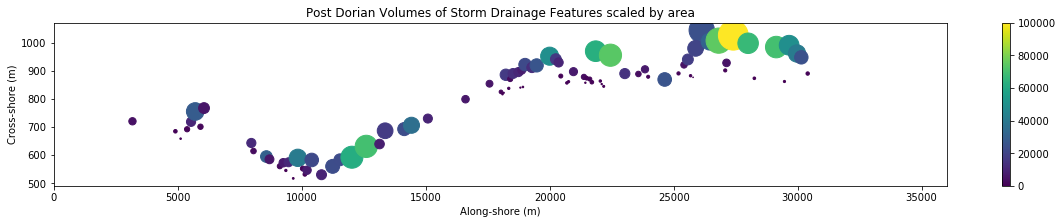

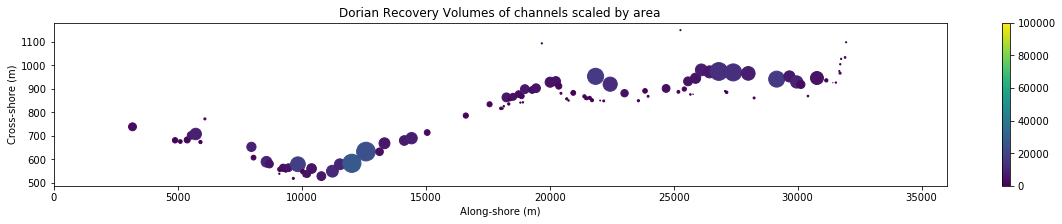

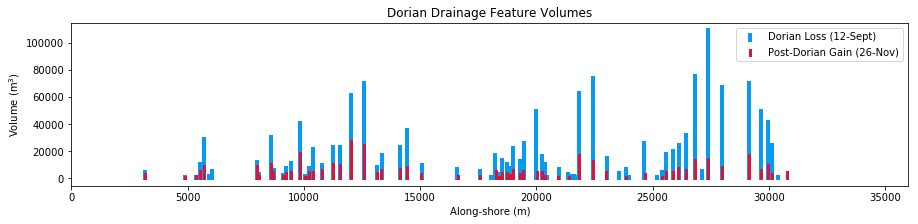

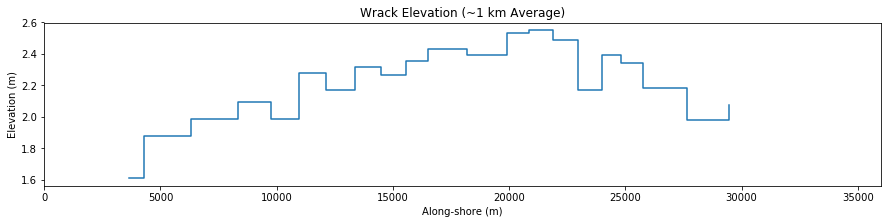

In [232]:
#Plot Channel Locations
s_pD = 0.01*area_pD
s_DR = 0.01*area_DR

fig = plt.figure(figsize=(20,3))
plt.scatter(xisl_pD,yisl_pD,s_pD,vol_pD)
#plt.scatter(xisl_DR,yisl_DR,s_DR,vol_DR, edgecolors=(0,0,0))
plt.xlabel('Along-shore (m)')
plt.xlim([0,36000])
plt.ylabel('Cross-shore (m)')
plt.title('Post Dorian Volumes of Storm Drainage Features scaled by area')
plt.colorbar()
plt.clim(0,100000)


fig = plt.figure(figsize=(20,3))
plt.scatter(xisl_DR,yisl_DR,s_DR,vol_DR)
plt.xlabel('Along-shore (m)')
plt.xlim([0,36000])
plt.ylabel('Cross-shore (m)')
plt.title( 'Dorian Recovery Volumes of channels scaled by area')
plt.colorbar()
plt.clim(0,100000)

#Stem Plot for Volumes
fig = plt.figure(figsize=(15,3))
markers, stemlines, baseline = plt.stem(xisl_pD, vol_pD)
markers2, stemlines2, baseline2 = plt.stem(xisl_DR, vol_DR)

plt.setp(stemlines, linewidth =4, color = 'xkcd:azure')
plt.setp(baseline, visible = False)
plt.setp(markers, markersize = 0 )

plt.setp(stemlines2, linewidth =3, color = 'crimson')
plt.setp(baseline2, visible = False)
plt.setp(markers2, markersize = 0 )

plt.xlabel('Along-shore (m)')
plt.ylabel('Volume (m$^3$)')
plt.xlim([0,36000])
#plt.ylim([0,20000])
plt.title( 'Dorian Drainage Feature Volumes')
plt.legend(['Dorian Loss (12-Sept)', 'Post-Dorian Gain (26-Nov)'])


#Plot wrack elevations
fig = plt.figure(figsize=(15,3))
plt.step(xisl_wr_avg,elev_wr_avg, where = 'mid')
plt.xlabel('Along-shore (m)')
plt.ylabel('Elevation (m)')
plt.xlim([0,36000])
plt.title( 'Wrack Elevation (~1 km Average)')




Number of Channelized Barrier Deposition Overwash Fans is 3
Number of Channelized Lagoonal Deposition Overwash Fans is 3
Number of Non-Channelized Lobate Overwash Fans is 36
Number of Non-Channelized Apron Sourced Overwash Fans is 9
Number of Non-Channelized Dissipative Overwash Fans is 39


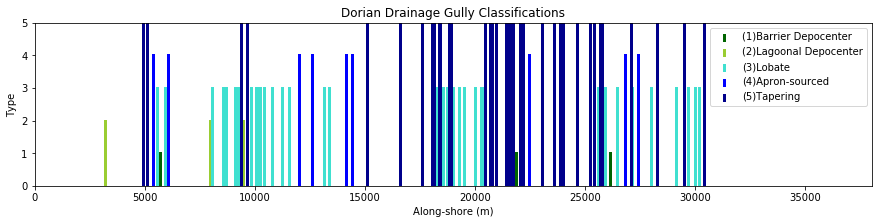

In [231]:
#Stem Plot for Channel Types based off of Huddock et al 2014 classfication
fig = plt.figure(figsize=(15,3))

Bdepo = [i for i, value in enumerate(Ch_type) if value == 1]
Ldepo = [i for i, value in enumerate(Ch_type) if value == 2]
lobate = [i for i, value in enumerate(Ch_type) if value == 3]
apron = [i for i, value in enumerate(Ch_type) if value == 4]
diss = [i for i, value in enumerate(Ch_type) if value == 5]

markers, stemlines, baseline = plt.stem(xisl_pD[Bdepo], Ch_type[Bdepo])
markers2, stemlines2, baseline2 = plt.stem(xisl_pD[Ldepo], Ch_type[Ldepo])
markers3, stemlines3, baseline3 = plt.stem(xisl_pD[lobate], Ch_type[lobate])
markers4, stemlines4, baseline4 = plt.stem(xisl_pD[apron], Ch_type[apron])
markers5, stemlines5, baseline5 = plt.stem(xisl_pD[diss], Ch_type[diss])

plt.setp(stemlines, linewidth =3, color = "darkgreen")
plt.setp(baseline, visible = False)
plt.setp(markers, markersize = 0 )

plt.setp(stemlines2, linewidth =3, color = "yellowgreen")
plt.setp(baseline2, visible = False)
plt.setp(markers2, markersize = 0 )

plt.setp(stemlines3, linewidth =3, color = "turquoise")
plt.setp(baseline3, visible = False)
plt.setp(markers3, markersize = 0 )

plt.setp(stemlines4, linewidth =3, color = "blue")
plt.setp(baseline4, visible = False)
plt.setp(markers4, markersize = 0 )

plt.setp(stemlines5, linewidth =3, color = "darkblue")
plt.setp(baseline5, visible = False)
plt.setp(markers5, markersize = 0 )




plt.xlabel('Along-shore (m)')
plt.ylabel('Type')
plt.xlim([0,38000])
plt.ylim([0,5])
plt.title( 'Dorian Drainage Gully Classifications')
plt.legend(['(1)Barrier Depocenter', '(2)Lagoonal Depocenter', '(3)Lobate', '(4)Apron-sourced','(5)Tapering'])

print 'Number of Channelized Barrier Deposition Overwash Fans is ' + str(len(Bdepo))
print 'Number of Channelized Lagoonal Deposition Overwash Fans is ' + str(len(Ldepo))
print 'Number of Non-Channelized Lobate Overwash Fans is ' + str(len(lobate))
print 'Number of Non-Channelized Apron Sourced Overwash Fans is ' + str(len(apron))
print 'Number of Non-Channelized Dissipative Overwash Fans is ' + str(len(diss))


R-squared of Dorian Data: 0.883 and h: 0.566
R-squared of Supplemental Data: 0.675 and h: 0.554
R-squared of All Data: 0.829 and h: 0.559


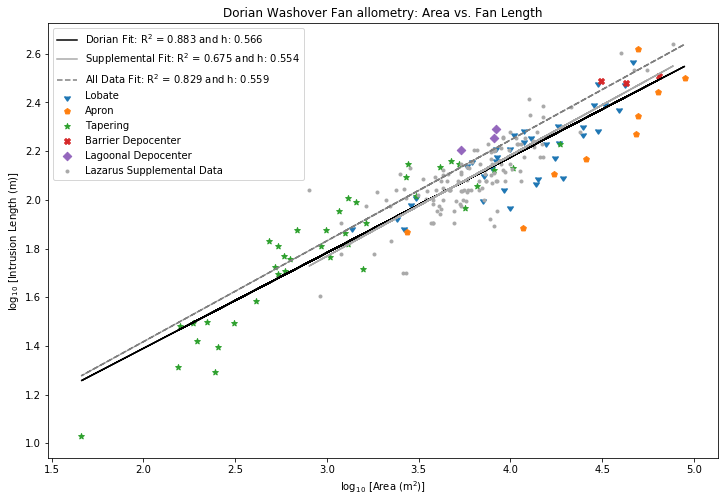

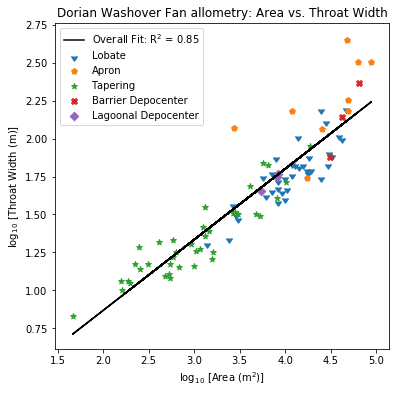

In [233]:
#Allometry of Post Dorian Channels

#Area vs Fan Length
fig = plt.figure(figsize=(12,8))
#m, b = np.polyfit(np.log10(area_pD), np.log10(Ch_length),1)
#plt.plot(np.log10(area_pD),m*np.log10(area_pD) + b, linestyle = '--', color = 'black')

#Stats
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(area_pD), np.log10(Ch_length))
h_Dorian = round(np.mean(np.log(Ch_length)/np.log(area_pD)),3)
plt.plot(np.log10(area_pD),slope*np.log10(area_pD) + intercept, linestyle = '-', color = 'black')
print ("R-squared of Dorian Data: "+ str(round(r_value**2,3)) + " and h: " + str(h_Dorian))

plt.scatter(np.log10(area_pD[lobate]),np.log10(Ch_length[lobate]), marker = 11)
plt.scatter(np.log10(area_pD[apron]),np.log10(Ch_length[apron]), marker = "p")
plt.scatter(np.log10(area_pD[diss]),np.log10(Ch_length[diss]), marker = "*")
plt.scatter(np.log10(area_pD[Bdepo]),np.log10(Ch_length[Bdepo]), marker = "X")
plt.scatter(np.log10(area_pD[Ldepo]),np.log10(Ch_length[Ldepo]), marker = "D")

#plt.scatter(np.log10(CB_05_area),np.log10(CB_05_length), marker = '.', color = 'gray')
#plt.scatter(np.log10(Hudock_area),np.log10(Hudock_length), marker = '.', color = 'lightgray')
#plt.scatter(np.log10(TV_area),np.log10(TV_length), marker = '.', color = 'darkgray')
plt.scatter(np.log10(sup_A),np.log10(sup_L), marker = '.', color = 'darkgray')
sup_A = np.concatenate([CB_05_area[0:64],TV_area[0:62]])
sup_L = np.concatenate([CB_05_length[0:64],TV_length[0:62]])
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(np.log10(sup_A), np.log10(sup_L))
h_sup = round(np.mean(np.log(sup_L)/np.log(sup_A)),3)
plt.plot(np.log10(sup_A),slope1*np.log10(sup_A) + intercept1, linestyle = '-', color = 'darkgray')
print ("R-squared of Supplemental Data: "+ str(round(r_value1**2,3)) + " and h: " + str(h_sup))

All_A = np.concatenate([sup_A,area_pD])
All_L = np.concatenate([sup_L,Ch_length])
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(np.log10(All_A), np.log10(All_L))
h_All = round(np.mean(np.log(All_L)/np.log(All_A)),3)
plt.plot(np.log10(All_A),slope1*np.log10(All_A) + intercept2, linestyle = '--', color = 'gray')
print ("R-squared of All Data: "+ str(round(r_value2**2,3)) + " and h: " + str(h_All))

plt.xlabel('log$_1$$_0$ [Area (m$^2$)]')
plt.ylabel('log$_1$$_0$ [Intrusion Length (m)]')
plt.title( 'Dorian Washover Fan allometry: Area vs. Fan Length')
plt.legend(['Dorian Fit: R$^2$ = '+ str(round(r_value**2,3))+ " and h: " + str(h_Dorian), 'Supplemental Fit: R$^2$ = ' + str(round(r_value1**2,3))+ " and h: " + str(h_sup)
            , 'All Data Fit: R$^2$ = ' + str(round(r_value2**2,3))+ " and h: " + str(h_All), 'Lobate', 'Apron', 'Tapering', 'Barrier Depocenter',
            'Lagoonal Depocenter', 'Lazarus Supplemental Data'])


#Area vs Throat Width
fig = plt.figure(figsize=(6,6))
#m, b = np.polyfit(np.log10(area_pD), np.log10(Ch_throat),1)
#plt.plot(np.log10(area_pD),m*np.log10(area_pD) + b, linestyle = '--', color = 'black')

#Stats
slope3, intercept3, r_value3, p_value3, std_err3 = stats.linregress(np.log10(area_pD), np.log10(Ch_throat))
plt.plot(np.log10(area_pD),slope3*np.log10(area_pD) + intercept3, linestyle = '-', color = 'black')

plt.scatter(np.log10(area_pD[lobate]),np.log10(Ch_throat[lobate]), marker = 11)
plt.scatter(np.log10(area_pD[apron]),np.log10(Ch_throat[apron]), marker = "p")
plt.scatter(np.log10(area_pD[diss]),np.log10(Ch_throat[diss]), marker = "*")
plt.scatter(np.log10(area_pD[Bdepo]),np.log10(Ch_throat[Bdepo]), marker = "X")
plt.scatter(np.log10(area_pD[Ldepo]),np.log10(Ch_throat[Ldepo]), marker = "D")

plt.xlabel('log$_1$$_0$ [Area (m$^2$)]')
plt.ylabel('log$_1$$_0$ [Throat Width (m)]')
plt.title( 'Dorian Washover Fan allometry: Area vs. Throat Width')
plt.legend(['Overall Fit: R$^2$ = ' + str(round(r_value3**2,3)),'Lobate', 'Apron', 'Tapering', 'Barrier Depocenter', 'Lagoonal Depocenter'])



In [70]:
#Post Dorian Channels - threshold -0.25 in diff map from 08-30 to 09-12
print 'Total number of channels: ' + str(len(area_pD))
print 'Sum of Channel Volume: ' + str(round(sum(vol_pD),1)) + ' m3'
print 'Total Channel Area: ' + str(round(sum(area_pD),1)) + ' m2'
print 'Mean Channel Depth: ' + str(round(np.mean(depth_pD),1)) + ' m'


Total number of channels: 99
Sum of Channel Volume: 1501798.6 m3
Total Channel Area: 1252439.5 m2
Mean Channel Depth: 1.0 m


In [127]:
#Post Dorian Channels Recovery - threshold 0.1 in diff map from 09-12 to 11-26
print 'Total number of channels: ' + str(len(area_DR))
print 'Sum of Channel Volume Gains: ' + str(round(sum(vol_DR),1)) + ' m3'
print 'Total Channel Area with Gains: ' + str(round(sum(area_DR),1)) + ' m2'
print 'Mean Depth of the Areas with Gains: ' + str(round(np.mean(depth_DR),1)) + ' m'

Total number of channels: 98
Sum of Channel Volume Gains: 390831.4 m3
Total Channel Area with Gains: 610534.0 m2
Mean Depth of the Areas with Gains: 0.5 m


Text(0.5,0,'Area (m2)')

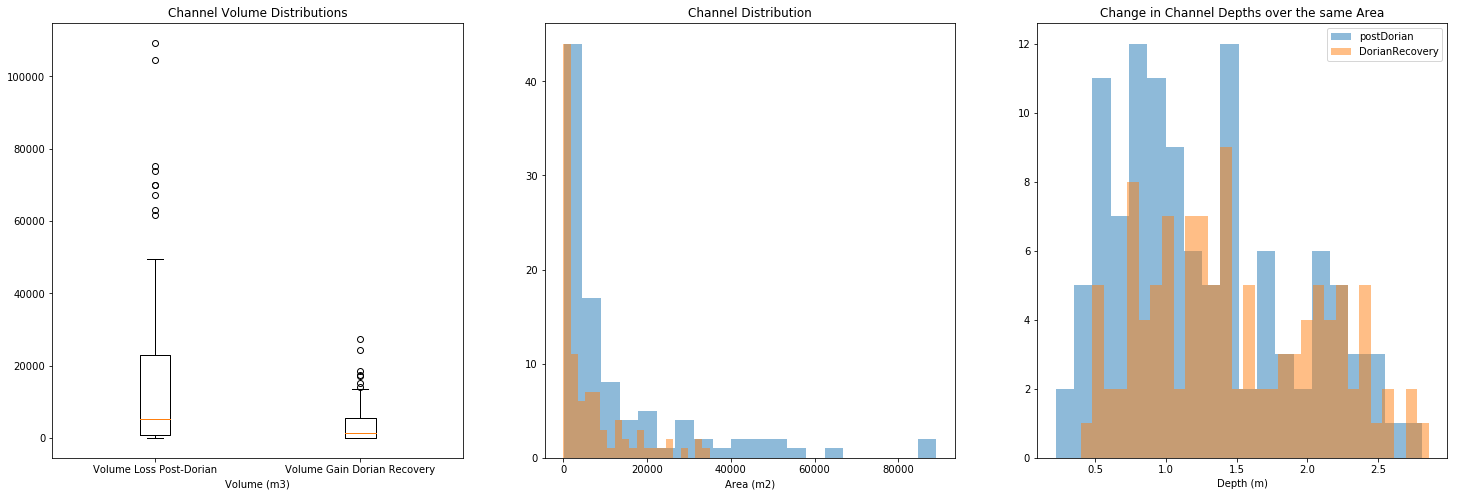

In [241]:
#Hisotgram plots
# def hist_plot(n, f, title):
#     #plt.clf()
#     plt.subplot(1, 3, n)
#     #plt.pcolor(X, Y, f(data), cmap=cm, vmin=-4, vmax=4)
#     plt.title(title)
n_bins = 20
bins = np.arange(0, 32000, 2000).tolist()
volumes = [vol_pD, vol_DR]

fig, axs = plt.subplots(1,3,figsize=(25,8))
axs[0].boxplot(volumes)#,bins = n_bins, alpha = 0.5)
#axs[0].boxplot(vol_DR)#,bins = n_bins, alpha = 0.5)
axs[0].set_title('Channel Volume Distributions')
axs[0].set_xlabel('Volume (m3)')
axs[0].set_xticklabels(['Volume Loss Post-Dorian','Volume Gain Dorian Recovery'])
# axs[0].set_ylabel('Frequency')

#axs[3].hist(depth_pD,bins = n_bins, alpha = 0.5)
#axs[3].hist(depth_DR,bins = n_bins, alpha = 0.5)
#axs[3].set_title('Depth (m)')

axs[2].hist(pD_Depths,bins = n_bins, alpha = 0.5)
axs[2].hist(DR_Depths,bins = n_bins, alpha = 0.5)
axs[2].set_title('Change in Channel Depths over the same Area')
axs[2].set_xlabel('Depth (m)')
axs[2].legend(['postDorian', 'DorianRecovery'])

axs[1].hist(area_pD,bins = n_bins, alpha = 0.5)
axs[1].hist(area_DR,bins = n_bins, alpha = 0.5)
axs[1].set_title('Channel Distribution')
axs[1].set_xlabel('Area (m2)')
#axs[2].set_ylabel('Undamped')
